<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики `RMSE` на тестовой выборке должно быть не больше 48.

Вам нужно:

- Загрузить данные и выполнить их ресемплирование по одному часу.
- Проанализировать данные.
- Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
- Проверить данные на тестовой выборке и сделать выводы.

**Данные лежат в файле `taxi.csv.` Количество заказов находится в столбце `num_orders` (от англ. number of orders, «число заказов»).**

Нам предстоит проанализировать исторические данные о заказах такси в аэропортах дл якомпании "Четенькое такси", чтобы можно было привлекать больше такси в пиковые нагрузки. Чтобы спрогнозировать количество заказов на следующий час мы обучим несколько моделей и проверим какая работает лучше. Лучшую модель протестируем на тестовой выборке

**Работа будет включать в себя 8 важных этапов:**

- Загрузка данных
- Изучение и подготовка данных
- Функция добавления фичей
- Анализ временного ряда
- Ресемплирование
- Обучение разных моделей
- Тестирование лучшей модели
- Подведение итогов

## Подготовка

В самом начале произведем все неообходимые импорты

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression

from sklearn.ensemble import RandomForestRegressor

from tqdm import tqdm

from catboost import CatBoostRegressor

Увеличим окно `Jupyter` до большей ширины

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

Также, чтобы не сильно мешало глазам, - уберем предупреждения и `warnings`

In [3]:
import warnings
warnings.filterwarnings("ignore") 

Загрузим датасет и посмотрим всю основную информацию о нём

In [4]:
df = pd.read_csv('/datasets/taxi.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [5]:
df.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


Выведем информацию о колонках и типах данных

In [6]:
df.dtypes

datetime      object
num_orders     int64
dtype: object

Первая проблема, которая сразу видна - тип данных для времени `object`, а нам нужен `datetime64`, поэтому тип данных нужно будет перевести, но перед этим проверить `df` на пропуски

**+** плюсом к этому, необходимо будет сделать эту колонку (`datetime`) индексами

Заменим тип данных для `datetime`

In [7]:
df['datetime'] = df['datetime'].astype('datetime64')

Проверим данные на пропуски

In [8]:
df.dtypes

datetime      datetime64[ns]
num_orders             int64
dtype: object

In [9]:
df.isna().sum()

datetime      0
num_orders    0
dtype: int64

Пропусков нет, отлично

Сделаем также `datetime` как индекс

In [10]:
df.index = df['datetime']
df = df.resample('1H').sum()

In [11]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Проверим также, что ряд монотонный

In [12]:
df.index.is_monotonic

True

## Анализ

**Что осталось добавить перед анализом:**

- Увеличение количества признаков с помощью функции для добавления новых фичей


**Функция:**

In [13]:
def make_features(df, max_lag, rolling_size_mean):
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)
        
        
    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_size_mean).mean()
    
    return df

In [14]:
df_init = df.copy()

In [15]:
%%time
df = make_features(df, 3, 7)
df.head(25)

CPU times: user 11.9 ms, sys: 0 ns, total: 11.9 ms
Wall time: 11.3 ms


,num_orders,year,month,day,dayofweek,lag_1,lag_2,lag_3,rolling_mean
datetime,,,,,,,,,
2018-03-01 00:00:00,124,2018,3,1,3,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,2018,3,1,3,124.0,NaN,NaN,NaN
2018-03-01 02:00:00,71,2018,3,1,3,85.0,124.0,NaN,NaN
2018-03-01 03:00:00,66,2018,3,1,3,71.0,85.0,124.0,NaN
2018-03-01 04:00:00,43,2018,3,1,3,66.0,71.0,85.0,NaN
2018-03-01 05:00:00,6,2018,3,1,3,43.0,66.0,71.0,NaN
2018-03-01 06:00:00,12,2018,3,1,3,6.0,43.0,66.0,NaN
2018-03-01 07:00:00,15,2018,3,1,3,12.0,6.0,43.0,58.142857
2018-03-01 08:00:00,34,2018,3,1,3,15.0,12.0,6.0,42.571429


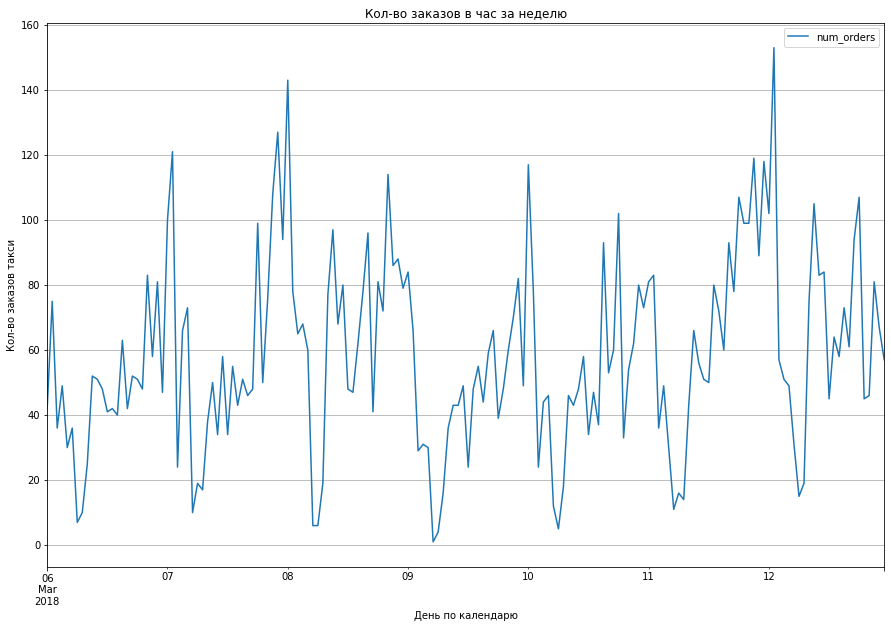

In [16]:
plt.figure(figsize = (15,10))
plt.ylabel('Кол-во заказов такси')
df['num_orders']['2018-03-06':'2018-03-12'].plot(grid = True, 
                                                 title = 'Кол-во заказов в час за неделю', 
                                                 legend = True, 
                                                 xlabel = 'День по календарю')

plt.show()

Теперь к этому графику добавим **скользящее среднее**

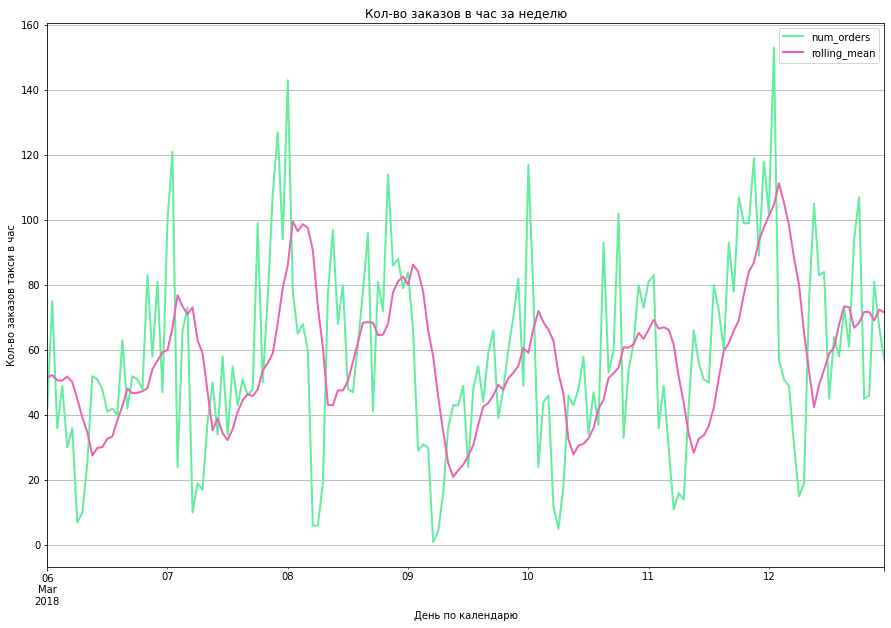

In [17]:
df[['num_orders','rolling_mean']]['2018-03-06':'2018-03-12'].plot(grid = True,
                                                                  title = 'Кол-во заказов в час за неделю',
                                                                  legend = True,
                                                                  xlabel = 'День по календарю',
                                                                  figsize = (15,10),
                                                                  fontsize = 10,
                                                                  color = ['#63ed9f', '#ed63b1'],
                                                                  ylabel = 'Кол-во заказов такси в час',
                                                                  linewidth = 2)

plt.show()

В целом, можно сказать, что пик заказов приходится либо на утро, либо на вторую половину дня, но что-то конкретное сказать сложно. Поэтому сделаем декомпозицию и посмотрим на данные более детально

In [18]:
decomposed = seasonal_decompose(df['num_orders'])

Теперь выведем показатели для `decomposed`

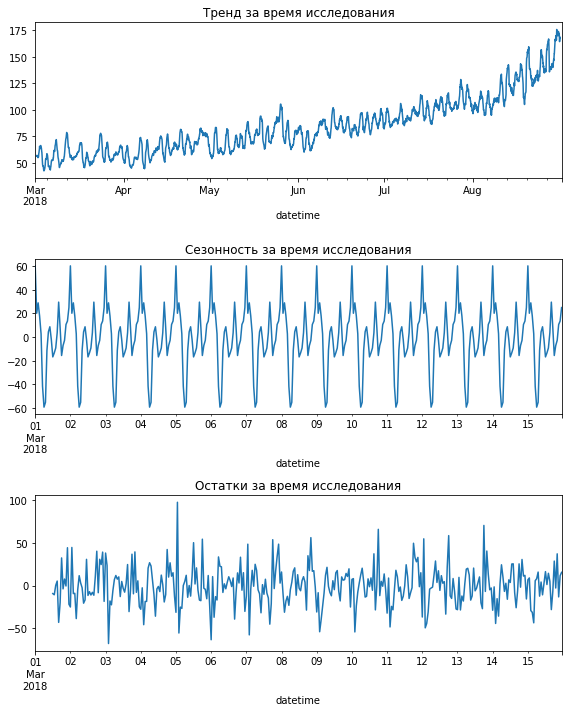

In [19]:
plt.figure(figsize=(8, 10))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд за время исследования')

plt.subplot(312)
decomposed.seasonal['2018-03-01':'2018-03-15'].plot(ax=plt.gca())
plt.title('Сезонность за время исследования')

plt.subplot(313)
decomposed.resid['2018-03-01':'2018-03-15'].plot(ax=plt.gca())
plt.title('Остатки за время исследования')

plt.tight_layout()

По графику четко видно, что спрос падает сильно ночью, а ближе к вечеру - возрастает

Также видно, что возрастает спрос на такси летом

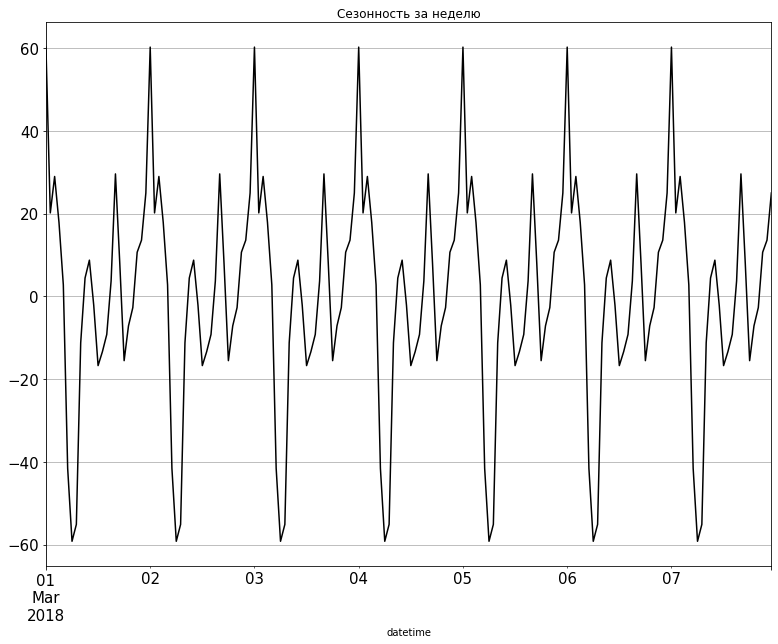

In [20]:
plt.figure(figsize = (13, 10))
decomposed.seasonal['2018-03-01':'2018-03-07'].plot(fontsize = 15, grid = True, color = 'black')
plt.title('Сезонность за неделю')

plt.show()

Итак, и правда есть увеличение трафика такси ближе к вечеру

Для прогноза значений также еще необходимо знать, стационарный ли ряд

**Стационарность ряда**

In [21]:
df

,num_orders,year,month,day,dayofweek,lag_1,lag_2,lag_3,rolling_mean
datetime,,,,,,,,,
2018-03-01 00:00:00,124,2018,3,1,3,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,2018,3,1,3,124.0,NaN,NaN,NaN
2018-03-01 02:00:00,71,2018,3,1,3,85.0,124.0,NaN,NaN
2018-03-01 03:00:00,66,2018,3,1,3,71.0,85.0,124.0,NaN
2018-03-01 04:00:00,43,2018,3,1,3,66.0,71.0,85.0,NaN
...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,2018,8,31,4,207.0,217.0,197.0,167.428571
2018-08-31 20:00:00,154,2018,8,31,4,136.0,207.0,217.0,167.428571
2018-08-31 21:00:00,159,2018,8,31,4,154.0,136.0,207.0,165.714286


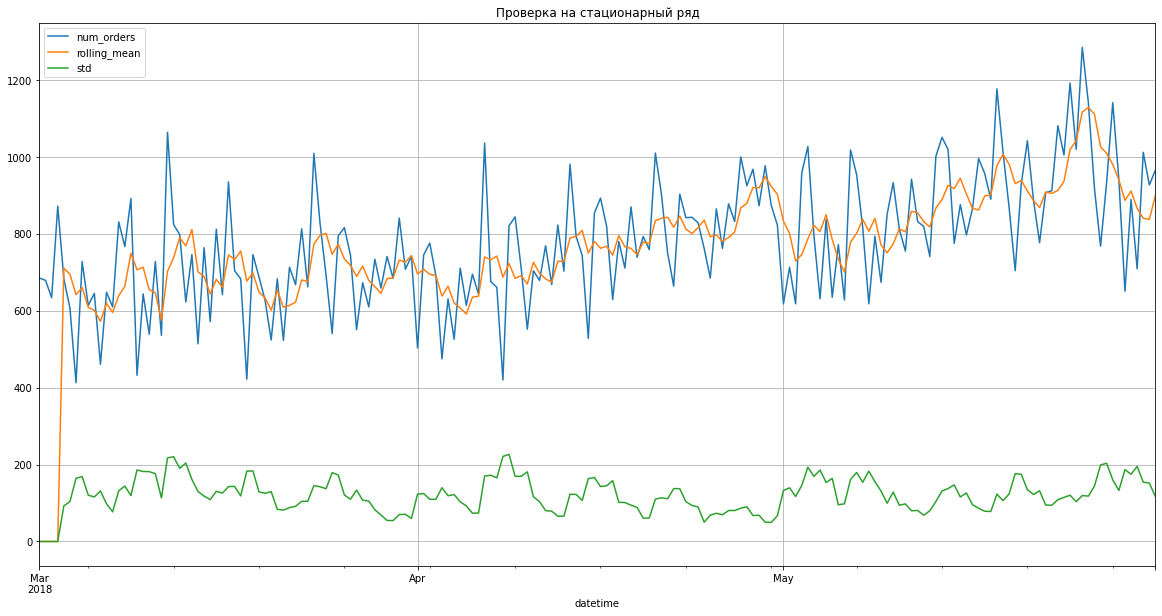

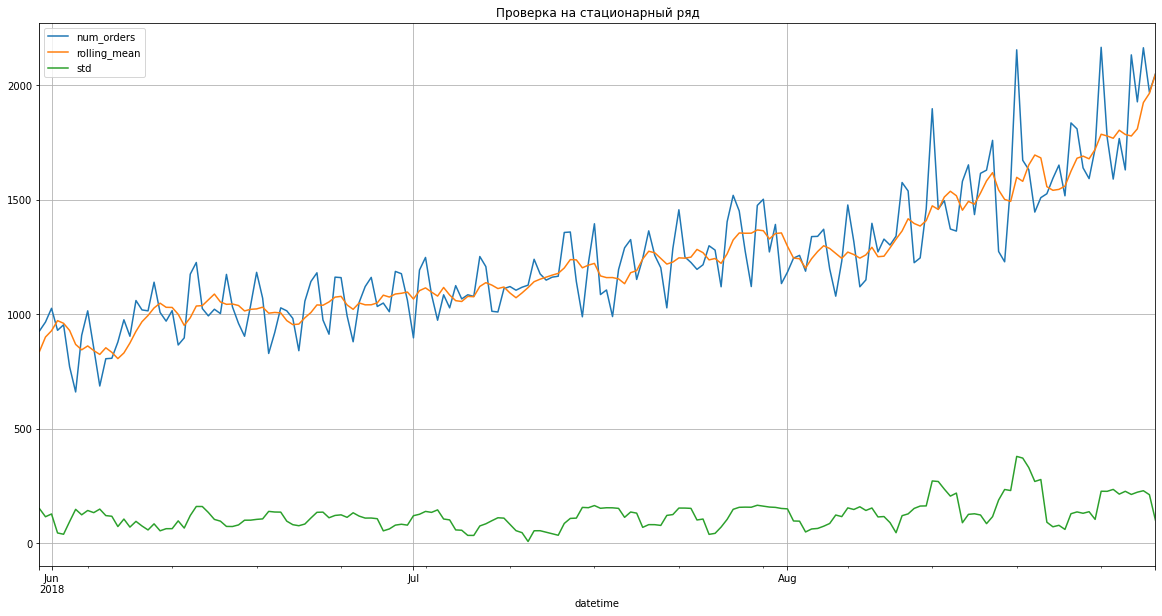

In [22]:
data = df[['num_orders']]

data['rolling_mean'] = data.resample('12H').sum()['num_orders'].rolling(5).mean()
data['std'] = data.resample('12H').sum()['num_orders'].rolling(5).std()

data[['num_orders','rolling_mean','std']].resample('12H').sum()['2018-03-01':'2018-05-31'].plot(figsize=(20,10),grid=True,title='Проверка на cтационарный ряд');
plt.show()

data[['num_orders','rolling_mean','std']].resample('12H').sum()['2018-05-31':'2018-08-31'].plot(figsize=(20,10),grid=True,title='Проверка на cтационарный ряд');

Ряд не стационарный, посмотрим дальше

Попробуем взять разные промежутки и для них построить графики, чтобы понять как делать прогноз

In [23]:
data_dif = data.copy()
data_dif

,num_orders,rolling_mean,std
datetime,,,
2018-03-01 00:00:00,124,NaN,NaN
2018-03-01 01:00:00,85,NaN,NaN
2018-03-01 02:00:00,71,NaN,NaN
2018-03-01 03:00:00,66,NaN,NaN
2018-03-01 04:00:00,43,NaN,NaN
...,...,...,...
2018-08-31 19:00:00,136,NaN,NaN
2018-08-31 20:00:00,154,NaN,NaN
2018-08-31 21:00:00,159,NaN,NaN


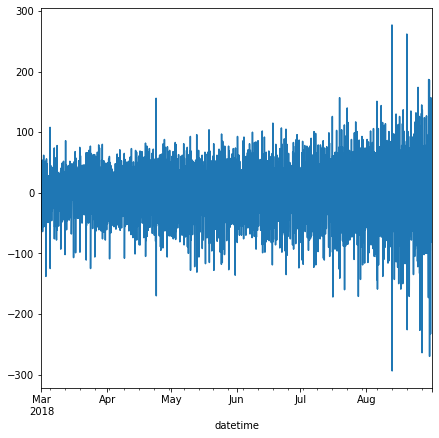

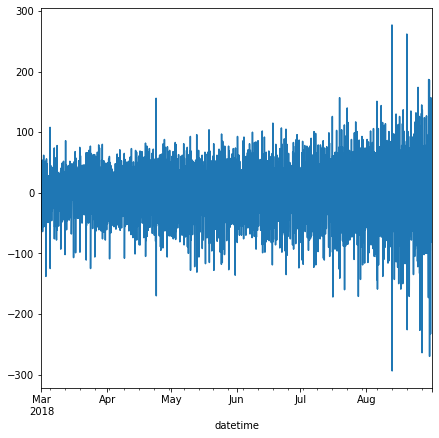

In [24]:
def find_target(data, n):
    for i in range(n):
        plt.figure(figsize = (7,7))
        data_dif['dif'] = data_dif['num_orders'] - data_dif['num_orders'].shift(n)
        data_dif['dif'].plot()
        plt.show()
        
find_target(data, 2)

В принципе, функцию можно было не делать, тк какой бы `n` не взяли бы, все равно график получится одинаковый)

Если использовать `shift()` метод, то ряд становится стационарными, поэтому как целевой признак возьмем разницу между `2` часами

**Итоги анализа**

- Среднее увеличивается, значит этот ряд не является стационарным рядом. Но среднее меняется медленно, это может не сильно повлиять на предсказание.

## Обучение

# Линейная регрессия

Каждый раз подбором будем искать оптимальные параметры

In [25]:
df.shape

(4416, 9)

In [26]:
df.head()

,num_orders,year,month,day,dayofweek,lag_1,lag_2,lag_3,rolling_mean
datetime,,,,,,,,,
2018-03-01 00:00:00,124,2018,3,1,3,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,2018,3,1,3,124.0,NaN,NaN,NaN
2018-03-01 02:00:00,71,2018,3,1,3,85.0,124.0,NaN,NaN
2018-03-01 03:00:00,66,2018,3,1,3,71.0,85.0,124.0,NaN
2018-03-01 04:00:00,43,2018,3,1,3,66.0,71.0,85.0,NaN


## Тестирование

In [27]:
%%time

lag = 25
rolling = 7
df = make_features(df, lag, rolling)

train, test = train_test_split(df, test_size = 0.1, shuffle = False, random_state = 1427)

train = train.dropna(axis = 0)

CPU times: user 24.7 ms, sys: 84 µs, total: 24.7 ms
Wall time: 23.7 ms


In [28]:
train.head()

,num_orders,year,month,day,dayofweek,lag_1,lag_2,lag_3,rolling_mean,lag_4,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,lag_25
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 01:00:00,120,2018,3,2,4,90.0,58.0,113.0,72.285714,66.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0
2018-03-02 02:00:00,75,2018,3,2,4,120.0,90.0,58.0,79.000000,113.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0
2018-03-02 03:00:00,64,2018,3,2,4,75.0,120.0,90.0,83.285714,58.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0
2018-03-02 04:00:00,20,2018,3,2,4,64.0,75.0,120.0,83.714286,90.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0
2018-03-02 05:00:00,11,2018,3,2,4,20.0,64.0,75.0,77.142857,120.0,...,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0


In [29]:
from sklearn.model_selection import GridSearchCV

In [30]:
%%time
features_train, target_train = train.drop('num_orders', axis = 1), train['num_orders']
features_test, target_test = test.drop('num_orders', axis = 1), test['num_orders']

cv_results_l = []

tscv = TimeSeriesSplit(n_splits = 7, test_size = 60, gap = 7)


for i, (train_index, test_index) in enumerate(tscv.split(features_test)):
    model_l = LinearRegression()
    
    model_l.fit(features_train.iloc[train_index], target_train.iloc[train_index])
    
    predictions_l = model_l.predict(features_train.iloc[test_index])
    
    rmse_l = mean_squared_error(target_train[test_index], predictions_l, squared = False)
    print(f"Fold {i}")
    print(f'Current RMSE = {rmse_l}')
    cv_results_l.append(rmse_l)
    
print()
cv_results_l = pd.Series(cv_results_l).mean()

print('RMSE кросс валидации линейной регрессии равен', cv_results_l)


print()
print()
print('____________________________________________')

# 2-ой способ c GridSearch
model_grid = LinearRegression()

param_lin = {
    'fit_intercept': (True, False),
    'normalize': (True, False),
    'n_jobs' : [None] + [i for i in range(2,10)]
}

# создаем экземпляр GridSearchCV
grid_lin = GridSearchCV(estimator=model_grid, param_grid = param_lin, cv= tscv)

# обучаем модель
grid_lin.fit(features_train, target_train)

# выводим лучшие параметры и результаты
print("Лучшие параметры:", grid_lin.best_params_)
print("Лучшее значение метрики:", grid_lin.best_score_)


Fold 0
Current RMSE = 29.859316158334522
Fold 1
Current RMSE = 33.30840734709482
Fold 2
Current RMSE = 63.150877534150965
Fold 3
Current RMSE = 23.714978805561667
Fold 4
Current RMSE = 17.905283644975636
Fold 5
Current RMSE = 20.289830713682974
Fold 6
Current RMSE = 22.52932491529024

RMSE кросс валидации линейной регрессии равен 30.1082884455844


____________________________________________
Лучшие параметры: {'fit_intercept': True, 'n_jobs': None, 'normalize': True}
Лучшее значение метрики: 0.4221085937685619
CPU times: user 13.9 s, sys: 15.1 s, total: 28.9 s
Wall time: 28.9 s


In [31]:
#m = LinearRegression()
#m.fit(features_train, target_train)
#p = m.predict(features_test)
#r = mean_squared_error(target_test, p, squared = False)
#r

# Случайный лес

In [32]:
from tqdm import tqdm
import time

In [33]:
%%time

lag = 25
rolling = 7
df = make_features(df, lag, rolling)

train, test = train_test_split(df, test_size = 0.1, shuffle = False, random_state = 1427)

train = train.dropna(axis = 0)

features_train, target_train = train.drop('num_orders', axis = 1), train['num_orders']
features_test, target_test = test.drop('num_orders', axis = 1), test['num_orders']

cv_results_f = []

tscv = TimeSeriesSplit(n_splits = 7, test_size = 60, gap = 7)

depthes = [None] + [i for i in range(2,7)]

for i, (train_index, test_index) in enumerate(tscv.split(features_test)):
    
    best_rmse = 1e300
    best_depth = -1
    best_est = -1
    
    for depth in tqdm(depthes):
        for est in range(10,125,25):
            model_f = RandomForestRegressor(n_estimators = est, max_depth = depth, random_state = 1427)
            
            model_f.fit(features_train.iloc[train_index], target_train.iloc[train_index])
            
            predictions_f = model_f.predict(features_train.iloc[test_index])
            
            rmse_f = mean_squared_error(target_train.iloc[test_index], predictions_f, squared = False)
            if rmse_f < best_rmse:
                best_rmse = rmse_f
                best_depth = depth
                best_est = est
    
    
    print(f"Fold {i}")

    print(f'RMSE кросс ансамбля деревьев на {i} Fold равен = ', best_rmse)
    cv_results_f.append(best_rmse)
    
cv_results_f = pd.Series(cv_results_f).mean()
print('Итоговое значение RMSE при Кросс Валидации = ', cv_results_f)



print()
print()
print('____________________________________________')

# 2-ой способ c GridSearch
#model_f = RandomForestRegressor()

#param_f = {
#    'n_estimators': [50, 100, 200],
#    'max_depth': [None, 5, 10],
#    'min_samples_split': [2, 5, 10],
#    'min_samples_leaf': [1, 2, 4]
#}

# создаем экземпляр GridSearchCV
#grid_f = GridSearchCV(estimator = model_f, param_grid = param_f, cv=15)

# обучаем модель
#grid_f.fit(features_train, target_train)

# выводим лучшие параметры и результаты
#print("Лучшие параметры:", grid_f.best_params_)
#print("Лучшее значение метрики:", grid_f.best_score_)
model_f = RandomForestRegressor()

param_f = {
    'n_estimators': [50, 60],
    'max_depth': [None, 1, 2],
    'min_samples_split': [1, 2, 3],
    'min_samples_leaf': [1, 2, 3]
}

# создаем экземпляр GridSearchCV
grid_f = GridSearchCV(estimator = model_f, param_grid = param_f, cv = tscv)

# инициализируем tqdm для отображения прогресса и времени обучения
#with tqdm(total=len(param_f['n_estimators']) * 
#          len(param_f['max_depth']) * 
#          len(param_f['min_samples_split']) * 
#          len(param_f['min_samples_leaf']), desc="Обучение модели") as pbar:
#    start_time = time.time()  # запоминаем время начала обучения
grid_f.fit(features_train, target_train)  # обучаем модель
#    pbar.update(1)  # обновляем прогресс-бар

# выводим лучшие параметры и результаты
print("Лучшие параметры:", grid_f.best_params_)
print("Лучшее значение метрики:", grid_f.best_score_)

#end_time = time.time()  # запоминаем время окончания обучения
#training_time = round(end_time - start_time, 2)  # вычисляем время обучения
#print("Время обучения: {} секунд".format(training_time))

100%|██████████| 6/6 [00:02<00:00,  2.54it/s]


Fold 0
RMSE кросс ансамбля деревьев на 0 Fold равен =  25.326608407056543


100%|██████████| 6/6 [00:03<00:00,  1.95it/s]


Fold 1
RMSE кросс ансамбля деревьев на 1 Fold равен =  20.02800224067795


100%|██████████| 6/6 [00:03<00:00,  1.67it/s]


Fold 2
RMSE кросс ансамбля деревьев на 2 Fold равен =  18.918897139460103


100%|██████████| 6/6 [00:04<00:00,  1.39it/s]


Fold 3
RMSE кросс ансамбля деревьев на 3 Fold равен =  20.867227095775487


100%|██████████| 6/6 [00:04<00:00,  1.23it/s]


Fold 4
RMSE кросс ансамбля деревьев на 4 Fold равен =  15.171826618858734


100%|██████████| 6/6 [00:05<00:00,  1.11it/s]


Fold 5
RMSE кросс ансамбля деревьев на 5 Fold равен =  18.82913350621959


100%|██████████| 6/6 [00:06<00:00,  1.00s/it]


Fold 6
RMSE кросс ансамбля деревьев на 6 Fold равен =  18.693153322238906
Итоговое значение RMSE при Кросс Валидации =  19.690692618612474


____________________________________________
Лучшие параметры: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 60}
Лучшее значение метрики: 0.5100332584522427
CPU times: user 5min 33s, sys: 1.53 s, total: 5min 35s
Wall time: 5min 35s


In [34]:
cv_results_f

19.690692618612474

# CatBoost

In [35]:
df.columns

Index(['num_orders', 'year', 'month', 'day', 'dayofweek', 'lag_1', 'lag_2',
       'lag_3', 'rolling_mean', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8',
       'lag_9', 'lag_10', 'lag_11', 'lag_12', 'lag_13', 'lag_14', 'lag_15',
       'lag_16', 'lag_17', 'lag_18', 'lag_19', 'lag_20', 'lag_21', 'lag_22',
       'lag_23', 'lag_24', 'lag_25'],
      dtype='object')

In [36]:
%%time

lag = 25
rolling = 7
df = make_features(df, lag, rolling)

train, test = train_test_split(df, test_size = 0.1, shuffle = False, random_state = 1427)

train = train.dropna(axis = 0)

features_train, target_train = train.drop('num_orders', axis = 1), train['num_orders']
features_test, target_test = test.drop('num_orders', axis = 1), test['num_orders']

cv_results_c = []

c_features = ['year', 'month', 'day', 'dayofweek']


tscv = TimeSeriesSplit(n_splits = 7, test_size = 60, gap = 7)



for i, (train_index, test_index) in enumerate(tscv.split(features_test)):
    
    model_c = CatBoostRegressor(iterations = 500, learning_rate = 0.15, loss_function = 'RMSE')
    
    model_c.fit(features_train.iloc[train_index], target_train.iloc[train_index],cat_features=c_features,verbose=False)
    
    predictions_c = model_c.predict(features_train.iloc[test_index])
    
    rmse_c = mean_squared_error(target_train.iloc[test_index], predictions_c, squared = False)
    
    print(f"Fold {i}:")
    print(f'RMSE CatBoost = {rmse_c}')
    cv_results_c.append(rmse_c)
        
print()
cv_results_c = pd.Series(cv_results_c).mean()
            
print('RMSE кросс валидации CatBoost равен = ',cv_results_c)


# 2-ой вариант с GridSearch
model_catboost = CatBoostRegressor()

#param_catboost = {
    #'learning_rate': [0.01, 0.05],
    #'depth': [4, 6],
    #'l2_leaf_reg': [1, 3],
    #'iterations': [100, 200]
#}


param_catboost = {
    'iterations' : [500],
    'learning_rate' : [0.1, 0,15],
    'loss_function' : ['RMSE']
}


grid_catboost = GridSearchCV(estimator=model_catboost, param_grid=param_catboost, cv= tscv)

#total_combinations = len(param_catboost['learning_rate']) * len(param_catboost['depth']) * len(param_catboost['l2_leaf_reg']) * len(param_catboost['iterations'])
#with tqdm(total=total_combinations, desc="Обучение модели CatBoost") as pbar:
#    def update_pbar(*args):
#        pbar.update()
grid_catboost.fit(features_train, target_train, verbose=False)

print("Лучшие параметры:", grid_catboost.best_params_)
print("Лучшее значение метрики:", grid_catboost.best_score_)
            

Fold 0:
RMSE CatBoost = 26.236943107343382
Fold 1:
RMSE CatBoost = 21.198246861120527
Fold 2:
RMSE CatBoost = 19.40267079463104
Fold 3:
RMSE CatBoost = 21.89904870868012
Fold 4:
RMSE CatBoost = 13.81905214262611
Fold 5:
RMSE CatBoost = 17.893192217669156
Fold 6:
RMSE CatBoost = 18.21196457334446

RMSE кросс валидации CatBoost равен =  19.808731200773543


learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
Custom logger is already specified. Specify more than one logger at same time is not thread safe.learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
Custom logger is already specified. Specify more than one logger at same time is not thread safe.learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
Custom logger is already s

Лучшие параметры: {'iterations': 500, 'learning_rate': 0.1, 'loss_function': 'RMSE'}
Лучшее значение метрики: 0.5446976775460668
CPU times: user 43 s, sys: 1.14 s, total: 44.1 s
Wall time: 1min 1s


**Сравним все метрики**

In [37]:
print(f'RMSE Линейной регрессии на кросс-валидации равен = {cv_results_l}')
print()
print(f'RMSE Случайного леса на кросс-валидации равен = {cv_results_f}')
print()
print(f'RMSE CatBoost на кросс-валидации равен = {cv_results_c}')
print()

RMSE Линейной регрессии на кросс-валидации равен = 30.1082884455844

RMSE Случайного леса на кросс-валидации равен = 19.690692618612474

RMSE CatBoost на кросс-валидации равен = 19.808731200773543



Лучший результат у Леса и Кэта, он отличается совсем незначительно. Как основную модель возьмем Ансамбль

**Проверка на тестовых значениях**

In [38]:
%%time

lag = 25
rolling = 7
df = make_features(df, lag, rolling)

train, test = train_test_split(df, test_size = 0.1, shuffle = False, random_state = 1427)

train = train.dropna(axis = 0)

features_train, target_train = train.drop('num_orders', axis = 1), train['num_orders']
features_test, target_test = test.drop('num_orders', axis = 1), test['num_orders']

cv_results_f = []

tscv = TimeSeriesSplit(n_splits = 7, test_size = 60, gap = 7)

model_f = RandomForestRegressor(n_estimators = best_est, max_depth = best_depth, random_state = 1427)
            
model_f.fit(features_train, target_train)
            
predictions_f = model_f.predict(features_test)
            
rmse_f_total = mean_squared_error(target_test, predictions_f, squared = False)

print(f'Итоговое значение метрики RMSE = {rmse_f_total}')

Итоговое значение метрики RMSE = 45.55896573517994
CPU times: user 2.78 s, sys: 4.43 ms, total: 2.79 s
Wall time: 2.79 s


Модель получила быстро значения и `RMSE_total` получился равен 45, что нас вполне устраивает

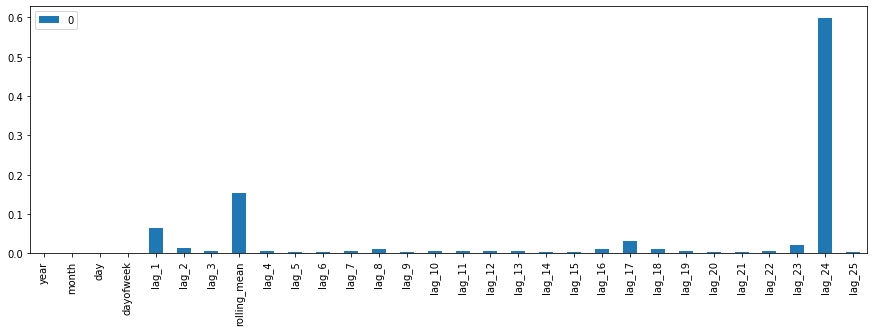

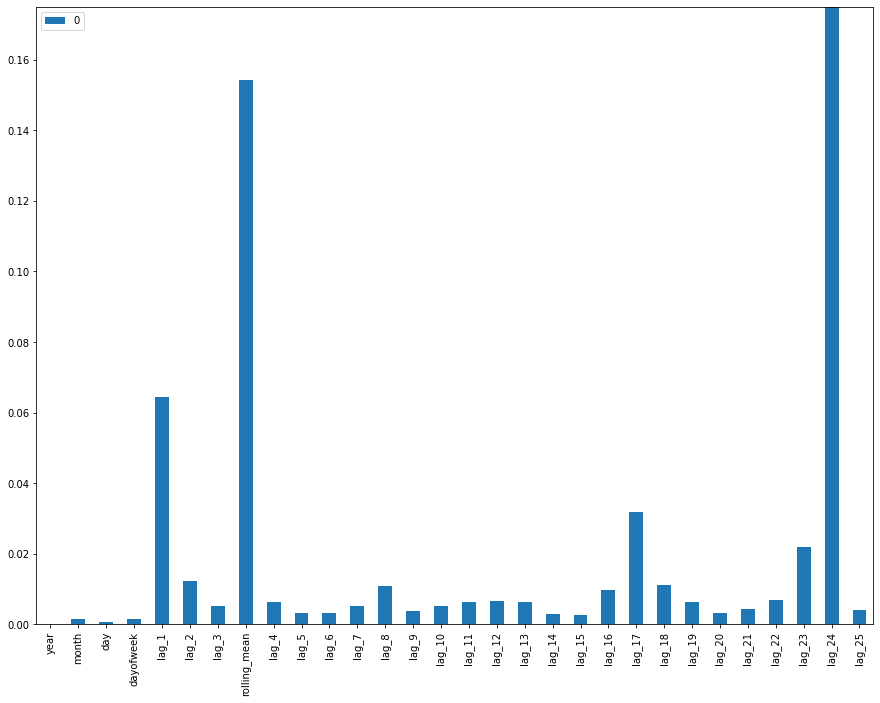

In [39]:
plt.subplot(211)
pd.DataFrame(model_f.feature_importances_, features_train.columns).plot(kind = 'bar', 
                                                                        figsize = (15,10), 
                                                                        ax = plt.gca())
plt.show()
plt.subplot(212)
pd.DataFrame(model_f.feature_importances_, features_train.columns).plot(kind = 'bar', 
                                                                        figsize = (15,25),
                                                                        ax = plt.gca(),
                                                                        ylim = (0.0,0.175))
plt.show()

Построим график для истинных и предсказанных значений

In [40]:
visual_2 = pd.DataFrame(predictions_f,columns=['prediction'],index = test.index)
visual_2

,prediction
datetime,
2018-08-13 14:00:00,108.698876
2018-08-13 15:00:00,125.315840
2018-08-13 16:00:00,131.015366
2018-08-13 17:00:00,129.171308
2018-08-13 18:00:00,103.250536
...,...
2018-08-31 19:00:00,119.047891
2018-08-31 20:00:00,152.928196
2018-08-31 21:00:00,169.814844


In [41]:
visual = test['num_orders']
visual = pd.concat([visual,visual_2], axis=1)
visual

,num_orders,prediction
datetime,,
2018-08-13 14:00:00,102,108.698876
2018-08-13 15:00:00,175,125.315840
2018-08-13 16:00:00,144,131.015366
2018-08-13 17:00:00,152,129.171308
2018-08-13 18:00:00,104,103.250536
...,...,...
2018-08-31 19:00:00,136,119.047891
2018-08-31 20:00:00,154,152.928196
2018-08-31 21:00:00,159,169.814844


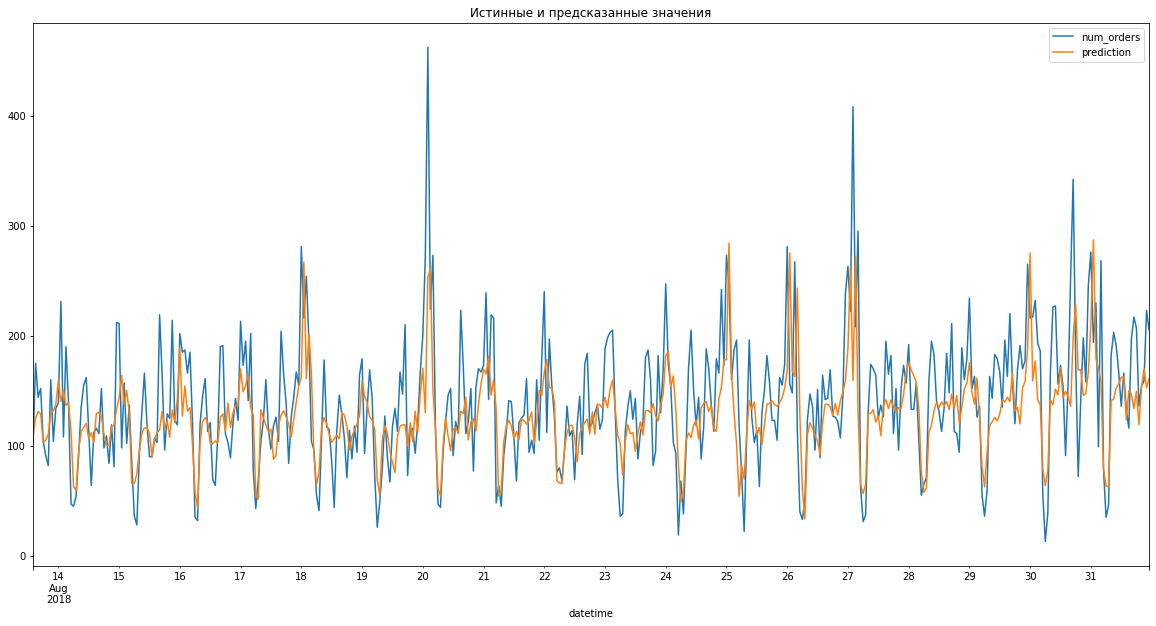

In [42]:
visual.plot(figsize = (20,10))
plt.title('Истинные и предсказанные значения')
plt.fontsize = 15
plt.show()

По итогу, предсказания довольно точно описывают спрос на такси

# Подведение итогов
    Нам предстояло проанализировать исторические данные о заказах такси в аэропортах для компании "Четенькое такси", чтобы можно было привлекать больше такси в пиковые нагрузки. 
    Чтобы спрогнозировать количество заказов на следующий час мы обучили несколько моделей и проверили какая работает лучше. 
    Лучшей оказалась модель `RandomForestRegressor`
    
- Лучшую модель протестировали на тестовой выборке, она показала метрику `RMSE` = 45, что ниже необходимого порога.

**Работа включила в себя 8 важных этапов:**

- Загрузка данных
- Изучение и подготовка данных
- Функция добавления фичей
- Анализ временного ряда
- Ресемплирование
- Обучение разных моделей
- Тестирование лучшей модели
- Подведение итогов

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48